# Importation des modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

from PIL.Image import *

from imageio import imread
import glob
from tqdm import tnrange
from tqdm.notebook import tqdm_notebook
import tqdm
import torch
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.utils import save_image

import multiprocessing
import time

In [2]:
torch.cuda.is_available()

True

# Création du train_set et test_set

## Chargement du dataset

In [3]:
size = 120

In [4]:
deep = 3

In [5]:
def image_to_numpy(image) :
    n = len(image)
    image_bis = []
    for i in range (n) :
        image_bis.append([])
        for j in range(n) :
            image_bis[i].append(image[i][j][0])
    return np.array(image_bis)

In [6]:
list_images = []
list_labels = []

list_path = set()

path_imgs = "trans100/"

def select_unique_imgs():
    for image_path in tqdm_notebook(glob.glob(path_imgs + "*.png")):
        label = image_path.find('l')
        couche = image_path.find('c')
        id_image = image_path[:couche]
        label_image = int(image_path[label+1:couche])
        list_path.add((id_image, label_image))



def load_pictures(data_files):
    with multiprocessing.Pool() as p :
        res = list(tqdm.tqdm(p.imap(load_image3.load_img_from_path, data_files), total=len(data_files)))
    for lot_lab, lot_img in tqdm.tqdm(res, total=len(res)):
        list_images.append(lot_img)
        list_labels.append(lot_lab)

In [7]:
select_unique_imgs()

In [8]:
import load_image3


if __name__ ==  '__main__' : 
    load_pictures(list_path)

100%|█████████████████████████████████████████████████████████████████████████| 8283/8283 [00:00<00:00, 2070036.35it/s]


## Renumérotation des labels

nombre de classes :  93
répartition des labels :


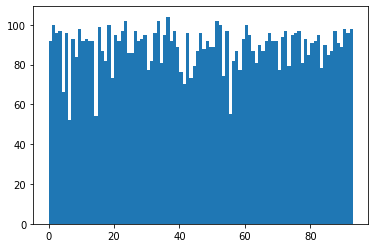

In [9]:
num_label = np.histogram(list_labels, bins=range(max(list_labels)+2))[0]
nouv_label = [-1]*(max(list_labels)+2)
compteur = 0
for i in range(max(list_labels)+1) :
    if num_label[i]>0 :
        nouv_label[i]=compteur
        compteur+=1
        
label_max = max(nouv_label)

num_classes = label_max+1

print("nombre de classes : ", num_classes)

nouv_list_labels = []
for i in range(len(list_labels)) :
    nouv_list_labels.append(nouv_label[list_labels[i]])

plt.hist(nouv_list_labels, bins=range(label_max +2))

print("répartition des labels :")

## Mélange et transformation pytorch du dataset en train_set et test_set

In [10]:
def shuffle_in_unison(list_images, list_labels):
    assert len(list_images) == len(list_labels)
    shuffled_list_images = np.empty(list_images.shape, dtype=list_images.dtype)
    shuffled_list_labels = np.empty(list_labels.shape, dtype=list_labels.dtype)
    permutation = np.random.permutation(len(list_images))
    for old_index, new_index in enumerate(permutation):
        shuffled_list_images[new_index] = list_images[old_index]
        shuffled_list_labels[new_index] = list_labels[old_index]
    return shuffled_list_images, shuffled_list_labels

In [11]:
len(list_images[3])

3

In [12]:
def list_to_torch(list_images, list_labels) :
    n = len(list_images)
    
    torch_images=np.array([np.asarray(data) for data in list_images])
    torch_labels=np.array(list_labels)
    
    torch_images, torch_labels=shuffle_in_unison(torch_images, torch_labels)
    
    torch_images = torch.from_numpy(torch_images).cuda()
    torch_labels = torch.from_numpy(torch_labels).cuda()
    
    train_set = torch.utils.data.TensorDataset(torch_images[:int(0.8*n)],torch_labels[:int(0.8*n)])
    test_set = torch.utils.data.TensorDataset(torch_images[int(0.8*n):],torch_labels[int(0.8*n):])
    
    return train_set, test_set

In [13]:
train_set, test_set = list_to_torch(list_images, nouv_list_labels)

In [14]:
print(train_set[0][0].shape)

torch.Size([3, 120, 120])


# Définition et entraînement du réseau de neurones

In [15]:
def train_epoch(net, train_set, opt, criterion, batch_size):
    net.train()
    trainloader = torch.utils.data.DataLoader(train_set, batch_size)
    for x_batch, y_batch in trainloader :
        opt.zero_grad()
        # Forward
        y_pred = net(x_batch.float())
        y_batch = y_batch.long()
        # Compute diff
        loss = criterion(y_pred, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()

def accuracy(net, dataset):
    net.eval()
    correct = 0
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    for x_batch, y_batch in trainloader :
        y_pred = net(x_batch.float())
        y_pred = torch.argmax(y_pred).int()
        if int(y_pred)==int(y_batch[0]) :
            correct+=1
    return correct/len(dataset)

In [16]:
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth', # bn: batch normalization
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth'
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
  layers = []
  prec_deep = 3
  for truc in cfg :
    if truc=='M' :
      layers.append(nn.MaxPool2d(2,None,0))
    else :
      layers.append(nn.Conv2d(prec_deep,truc,3,1,1))
      if batch_norm :
        layers.append(nn.BatchNorm2d(truc))
      layers.append(nn.ReLU(inplace=True))
      prec_deep = truc
  return nn.Sequential(*layers)



cfg = { # M stands for max pooling 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [17]:
def vgg_11_classifier(num_classes):
  classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
  return classifier
  
def vgg11_bn(num_classes, pretrained=False, letter='A', **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg[letter], batch_norm=True), **kwargs) # change cfg version for bonus
    if pretrained:
      if letter == 'A' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn'])) # change model url for bn
      elif letter == 'E' :
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
      else :
        print("Lettre non prise en charge")
    model.classifier = vgg_11_classifier(num_classes)
    return model

In [18]:
debut = time.time()

epochs = 300
criterion = nn.CrossEntropyLoss()

net = vgg11_bn(num_classes=num_classes, pretrained=False).cuda()


opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

compteur = 0

preci_train = []
preci_test = []

preci_train.append(accuracy(net, train_set))
preci_test.append(accuracy(net, test_set))

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=100)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :", accuracy(net, test_set)) 

fin = time.time()
duree = fin-debut
print("temps d'exécution :", duree/60, "min")

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


KeyboardInterrupt: 

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


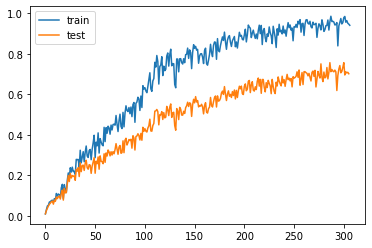

accuracy : 0.7012673506336753
temps d'exécution : 220.2524854938189 min


In [20]:
for i in tnrange(100) :
    train_epoch(net, train_set, opt, criterion, batch_size=100)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :", accuracy(net, test_set)) 

fin = time.time()
duree = fin-debut
print("temps d'exécution :", duree/60, "min")

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


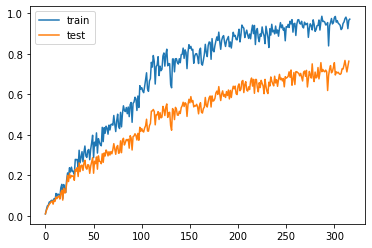

accuracy : 0.7634278817139408
temps d'exécution : 237.13747121493023 min


In [21]:
for i in tnrange(10) :
    train_epoch(net, train_set, opt, criterion, batch_size=25)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label = "test")
plt.legend()
plt.show()

print("accuracy :", accuracy(net, test_set)) 

fin = time.time()
duree = fin-debut
print("temps d'exécution :", duree/60, "min")